# АНСАМБЛИ МОДЕЛЕЙ

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jupyterthemes import jtplot
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
jtplot.style()

## Часть 0. Деревья решений

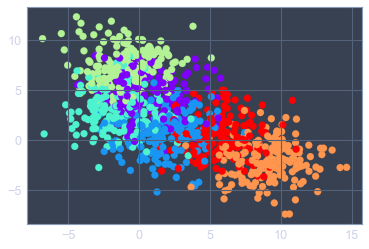

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, centers=6,
                  random_state=0, cluster_std=2.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
plt.show()

In [3]:
def visualize_tree(estimator, X, y, ax=None, fit=True):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    if fit:
        estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis',
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

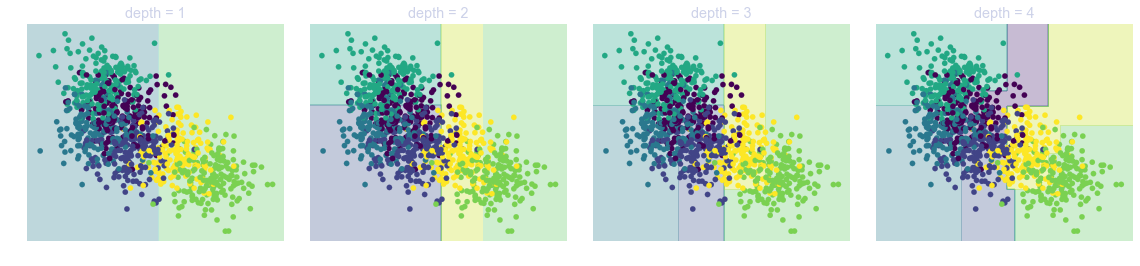

In [4]:
from sklearn.tree import DecisionTreeClassifier
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)
for axi, depth in zip(ax, range(1, 5)):
    model = DecisionTreeClassifier(max_depth=depth)
    visualize_tree(model, X, y, ax=axi, fit=True)
    axi.set_title('depth = {0}'.format(depth))

### Переобучение деревьев
К сожалению, деревья решений склонны к переобучению. Пример - обучим два дерева решений на половине данных и сравним результаты

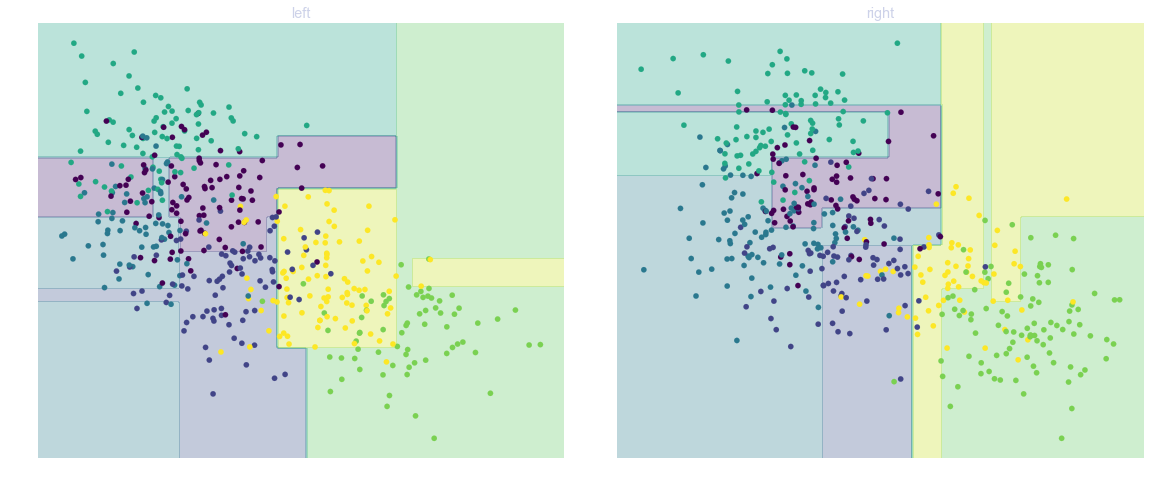

In [5]:
boundary = int(len(X) / 2)
X_left, y_left, X_right, y_right = X[:boundary], y[:boundary], X[boundary:], y[boundary:]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

model_left = DecisionTreeClassifier(max_depth=5)
visualize_tree(model_left, X_left, y_left, ax=ax[0])
ax[0].set_title('left')

model_right = DecisionTreeClassifier(max_depth=5)
visualize_tree(model_right, X_right, y_right, ax=ax[1])
ax[1].set_title('right')
plt.show()

# Часть 1 - Ансамбли

Давайте представим, что для решения задачи бинарной классификации мы вместо одной "хорошей" модели, создали 5 "плохих". Каждая с вероятностью 70% предсказывает правильный ответ и с вероятностью 30% - ошибается. Что если мы заставим эти модели голосовать за результат и будем выбирать предсказание на основе большинства голосов? Увеличиться ли качество модели?

In [6]:
# generate 1000 random numbers (between 0 and 1) for each model, representing 1000 observations
mod1 = np.random.rand(1000)
mod2 = np.random.rand(1000)
mod3 = np.random.rand(1000)
mod4 = np.random.rand(1000)
mod5 = np.random.rand(1000)

# each model independently predicts 1 (the "correct response") if random number was at least 0.3
preds1 = np.where(mod1 > 0.3, 1, 0)
preds2 = np.where(mod2 > 0.3, 1, 0)
preds3 = np.where(mod3 > 0.3, 1, 0)
preds4 = np.where(mod4 > 0.3, 1, 0)
preds5 = np.where(mod5 > 0.3, 1, 0)

# how accurate was each individual model?
print(preds1.mean())
print(preds2.mean())
print(preds3.mean())
print(preds4.mean())
print(preds5.mean())

0.699
0.677
0.666
0.676
0.711


In [7]:
# average the predictions and then round to 0 or 1
ensemble_preds = np.round((preds1 + preds2 + preds3 + preds4 + preds5)/5.0).astype(int)
# how accurate was the ensemble?
print(ensemble_preds.mean())

0.816


### Теорема Кондорсе «о жюри присяжных» (1784).
Если каждый член жюри присяжных имеет независимое мнение, и если вероятность правильного решения члена жюри больше 0.5, то тогда вероятность правильного решения присяжных в целом возрастает с увеличением количества членов жюри и стремится к единице. Если же вероятность быть правым у каждого из членов жюри меньше 0.5, то вероятность принятия правильного решения присяжными в целом монотонно уменьшается и стремится к нулю с увеличением количества присяжных.


$N$ — количество присяжных

$p$ — вероятность правильного решения присяжного

$μ$— вероятность правильного решения всего жюри

$m$ — минимальное большинство членов жюри, $m = \text{floor}(N/2) + 1$

$C^i_N$ - число сочетаний из $N$ по $i$

$$\large \mu = \sum_{i=m}^{N}C_N^ip^i(1-p)^{N-i}$$

Если $p>0.5$, то $\mu>p$

Если $N \rightarrow \infty$, то $\mu \rightarrow 1$

# Часть 2 - Беггинг

Беггинг - общий подход к уменьшению дисперсии алгоритма машинного обучения. Беггинг происходит от фразы bootstrap aggregation. Bootstrap выборка - это просто выборка с повторением

In [8]:
# set a seed for reproducibility
np.random.seed(1)

# create an array of 1 through 20
nums = np.arange(1, 21)
print(nums)

# sample that array 20 times with replacement
print(np.random.choice(a=nums, size=20, replace=True))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


Общий алгоритм:
1. Генерируем подвыборку $X_i$ размера $N$ с возвращением
2. Обучим базовый алгоритм $a_i(x)$ на выборке $X_i$
3. Повторяем шаги 1-2 $M$ раз
4. Усредняем (регрессия) или проводим голосование среди ответов $a_i(x)$

Замечания:

- Каждую подвыборку обычно делают размером с оригинальный набор данных
- Количество подвыборок должно быть достаточно, чтобы итоговая ошибка "стабилизировалась"

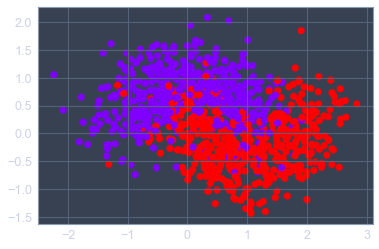

In [9]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, shuffle=True, noise=0.4, random_state=123)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
plt.show()

In [10]:
# Поделим на train и тест
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

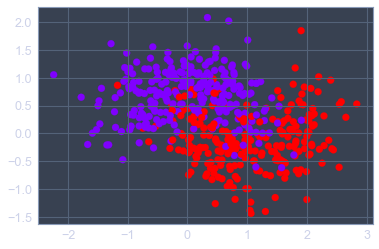

In [11]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='rainbow')
plt.show()

# Практика 1

Реализуйте беггинг над деревьями решений для этого примера (10 деревьев)

# Решение

In [12]:
estimators = 10
# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=X_train.shape[0], size=X_train.shape[0], replace=True) for _ in range(estimators)]

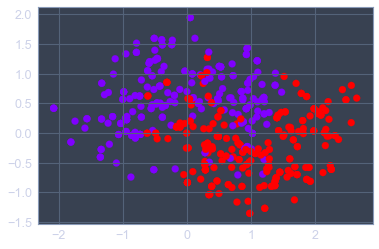

In [13]:
plt.scatter(X_train[samples[3], 0], X_train[samples[3], 1], c=y_train[samples[3]], s=50, cmap='rainbow')
plt.show()

In [83]:
models = []
for sample in samples:
    model = DecisionTreeClassifier(max_depth=None)
    model.fit(X_train[sample], y_train[sample])
    models.append(model)

In [84]:
def predict(models, X):
    predictions = None
    for m in models:
        if predictions is None:
            predictions = m.predict(X).reshape((-1, 1))
        else:
            predictions = np.hstack((predictions, m.predict(X).reshape((-1, 1))))
    result = []
    for p in predictions:
        result.append(np.bincount(p).argmax())
    return np.array(result)

In [85]:
y_pred = predict(models, X_test)
print(np.mean(y_pred == y_test))
print("MODELS")
for m in models:
    print(np.mean(m.predict(X_test) == y_test))

0.854
MODELS
0.796
0.836
0.818
0.806
0.806
0.804
0.808
0.802
0.83
0.806


# Конец Решения

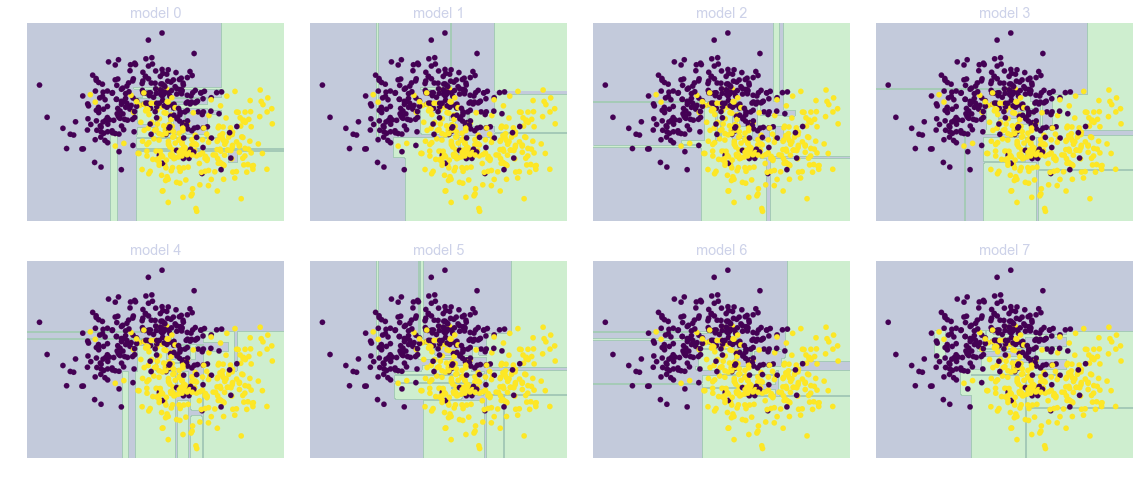

In [86]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)
for axi, index in zip(ax.flatten(), range(8)):
    visualize_tree(models[index], X_train, y_train, ax=axi, fit=False)
    axi.set_title('model {}'.format(index))

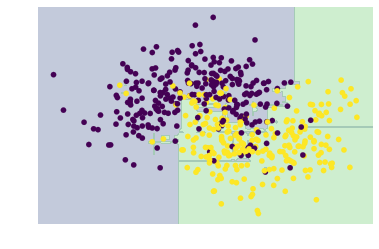

In [87]:
def visualize_bagg(models, X, y):
    ax = plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')

    xlim = ax.get_xlim()    
    ylim = ax.get_ylim()
    
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = predict(models, np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(Z))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis',
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
visualize_bagg(models, X_train, y_train)

### Практический пример

Используем данные страхового подразделения BNP Paribas из соревнования

https://www.kaggle.com/c/bnp-paribas-cardif-claims-management

Решается задача классификации страховых случаев:

1. Случаи, требующие дополнительных документов для подтвердения (0)    
2. Случаи, которые можно подтверждать автоматически на основе имеющейся информации (1)

In [219]:
data = pd.read_csv('train.csv')

In [220]:
# Уменьшим размер данных для ускорения обучения, возьмем случайную подвыборку 20% данных
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]

In [221]:
# Разбиваем на train/test
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=777)

for train_index, test_index in splitter.split(data, data.target):
    d_train = data.iloc[train_index]
    d_test = data.iloc[test_index]
    
    y_train = data['target'].iloc[train_index]
    y_test = data['target'].iloc[test_index]

In [168]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)

v3         3
v22     6610
v24        5
v30        7
v31        3
v47        9
v52       12
v56       90
v66        3
v71        5
v74        3
v75        4
v79       17
v91        7
v107       7
v110       3
v112      22
v113      34
v125      88
dtype: int64


In [169]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

Обучаем решающее дерево

Немного ограничим глубину и минимальное кол-во объектов в листе для уменьшения переобучения

In [170]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [171]:
def show_auc(y, y_pred, plot_label='', prin=True):    
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

Train:
ROC AUC: 0.8586
Test:
ROC AUC: 0.6482


0.6481938207330777

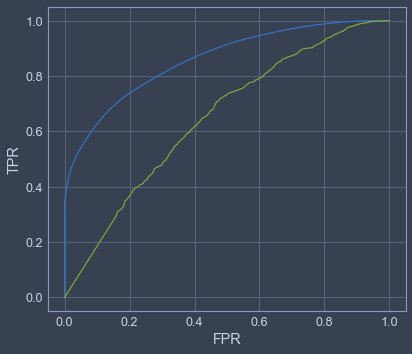

In [172]:
y_pred_test = clf_tree.predict_proba(X_test)[:, 1]
y_pred_train = clf_tree.predict_proba(X_train)[:, 1]

print('Train:')
show_auc(y_train, y_pred_train, 'train')
         
print('Test:')
show_auc(y_test, y_pred_test, 'test')

# Практика 2.

Применить наш беггинг к реальным данным

# Решение

Применим наш беггинг

In [195]:
def predict(models, X):
    predictions = None
    for m in models:
        if predictions is None:
            predictions = m.predict(X).reshape((-1, 1))
        else:
            predictions = np.hstack((predictions, m.predict(X).reshape((-1, 1))))
    result = []
    for p in predictions:
        result.append(np.bincount(p).argmax())
    return np.array(result)

def predict_proba(models, X):
    predictions = None
    for m in models:
        if predictions is None:
            # Берем только предсказания за первый класс
            predictions = m.predict_proba(X)[:, 1].reshape(-1, 1)
        else:
            predictions = np.hstack((predictions, m.predict_proba(X)[:, 1].reshape(-1, 1)))
    return np.mean(predictions, axis=1)

In [179]:
estimators = 20
samples = [np.random.choice(a=X_train.shape[0], size=X_train.shape[0], replace=True) for _ in range(estimators)]

models = []
for sample in samples:
    model = DecisionTreeClassifier(max_depth=None)
    model.fit(X_train.values[sample], y_train.values[sample])
    models.append(model)
    

Acc: 0.7583090379008747 auc:  0.682294289820142
MODELS
acc: 0.6785714285714286 auc: 0.5628218222052002
acc: 0.672740524781341 auc: 0.5705144572436798
acc: 0.6762390670553936 auc: 0.5713459165201793
acc: 0.6685131195335277 auc: 0.5601956875415322
acc: 0.6704081632653062 auc: 0.5587169012101989
acc: 0.6715743440233236 auc: 0.5697484672015503
acc: 0.6836734693877551 auc: 0.578743121638564
acc: 0.6677842565597668 auc: 0.5624404639149947
acc: 0.6801749271137026 auc: 0.5676460864128424
acc: 0.6906705539358601 auc: 0.5732829874921028
acc: 0.6787172011661807 auc: 0.5612415585605934
acc: 0.6776967930029154 auc: 0.5714653978729045
acc: 0.6763848396501457 auc: 0.5770982071250168
acc: 0.6704081632653062 auc: 0.570867991109278
acc: 0.677405247813411 auc: 0.5719024050123246
acc: 0.6810495626822157 auc: 0.5646590525947095
acc: 0.6801749271137026 auc: 0.5764451515121756
acc: 0.6807580174927114 auc: 0.5751521341333674
acc: 0.6902332361516035 auc: 0.5822138094256057
acc: 0.6733236151603499 auc: 0.566288

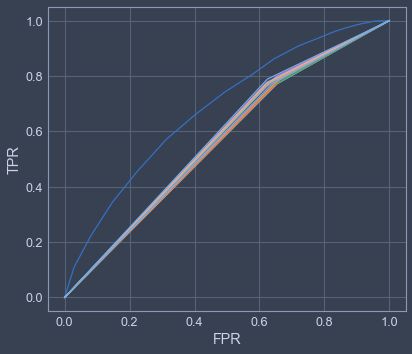

In [198]:
y_pred = predict(models, X_test)
y_proba = predict_proba(models, X_test)

print("Acc:", np.mean(y_pred == y_test), "auc: ", show_auc(y_test.values, y_proba, plot_label='Bagging', prin=False))

print("MODELS")
for i, m in enumerate(models):
    print("acc:", np.mean(m.predict(X_test) == y_test),
            "auc:", show_auc(y_test, m.predict_proba(X_test)[:, 1], prin=False, plot_label='model {}'.format(i)))
    
plt.show()
    

 # Конец решения

### Другой способ
Используем готовый алгоритм из sklearn

In [199]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(n_estimators=20, base_estimator=clf_tree, n_jobs=-1)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=20, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

Train:
ROC AUC: 0.8890
Test:
ROC AUC: 0.7190


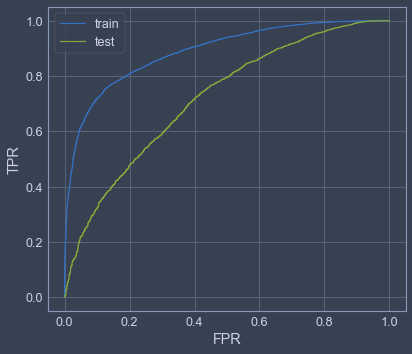

In [201]:
y_pred_test = bag_clf.predict_proba(X_test)[:, 1]
y_pred_train = bag_clf.predict_proba(X_train)[:, 1]

print('Train:')
show_auc(y_train, y_pred_train, 'train')
print('Test:')
show_auc(y_test, y_pred_test, 'test')
plt.legend();

# Часть 3. Случайный лес

Бэггинг + случайные подпространства = случайный лес

Случайный лес - вариация беггинга над деревьями, дающая даже лучшие результаты:
Как и в беггинге, мы создаем ансамбль деревьев решений, используя выборки из обучающего набора.
Однако при построении каждого дерева каждый раз, когда производится расщепление, признак выбирается из случайной выборки размера m из всех признаков.
Новая случайная выборка признаков формируется для каждого отдельного дерева в каждом отдельном расщеплении.
Для классификации $m$ обычно выбирается как квадратный корень из $p$.
Для регрессии $m$ обычно выбирается где-то между $p / 3$ и $p$.

В чем смысл?
Предположим, что в наборе данных есть один очень сильный признак. При использовании беггинга большая часть деревьев будет использовать этот признак в качестве первого, по которому производится деление, в результате чего образуется ансамбль похожих деревьев, которые сильно коррелированы.
Усреднение высококоррелированных величин не приводит к значительному уменьшению дисперсии (что является целью беггинга).
Случайно исключая признаки из каждого расщепления, Random Forest «декоррелирует» деревья, так что процесс усреднения может уменьшить дисперсию результирующей модели.

**Важные гиперпараметры алгоритма**

a. Параметры деревьев
1. criterion - критерий построения дерева
2. max_depth - максимальная глубина дерева (обычно 10-20, больше глубина -> больше риск переобучения)
3. min_samples_leaf - минимальное число объектов в листе (обычно 20+, больше объектов -> меньше риск переобучения)

b. Параметры леса
1. n_estimators - кол-во деревьев (чем больше тем лучше)
2. max_features - число признаков случайного подпространства
3. bootstrap - использовать ли бэггинг
4. n_jobs - кол-во потоков для одновременного построения деревьев (большая прибавка к скорости на многоядерных процах)

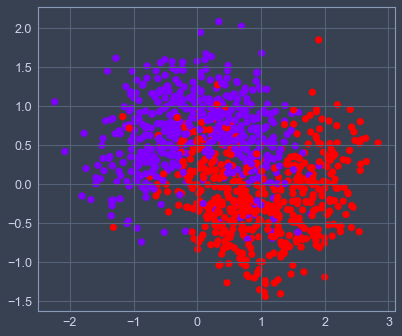

In [203]:
mX, my = make_moons(n_samples=1000, shuffle=True, noise=0.4, random_state=123)

mX_train, mX_test, my_train, my_test = train_test_split(mX, my, test_size=0.3)

plt.scatter(mX[:, 0], mX[:, 1], c=my, s=50, cmap='rainbow')
plt.show()

In [206]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(mX_train, my_train)   

bag_clf = BaggingClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier(), n_jobs=-1)
bag_clf.fit(mX_train, my_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

Train RF:
ROC AUC: 0.9512
Test RF:
ROC AUC: 0.9170
Train RF:
ROC AUC: 0.9997
Test RF:
ROC AUC: 0.8986


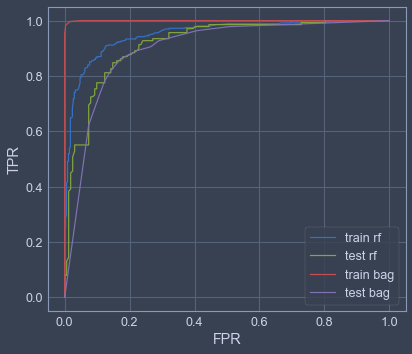

In [207]:
my_pred_test_rf = clf_rf.predict_proba(mX_test)[:, 1]
my_pred_train_rf = clf_rf.predict_proba(mX_train)[:, 1]
my_pred_test_bag = bag_clf.predict_proba(mX_test)[:, 1]
my_pred_train_bag = bag_clf.predict_proba(mX_train)[:, 1]

print('Train RF:')
show_auc(my_train, my_pred_train_rf, 'train rf')
print('Test RF:')
show_auc(my_test, my_pred_test_rf, 'test rf')
print('Train RF:')
show_auc(my_train, my_pred_train_bag, 'train bag')
print('Test RF:')
show_auc(my_test, my_pred_test_bag, 'test bag')

plt.legend();

# Практика 3
Применим случайный лес к нашему dataset'у

# Практика Решение

In [210]:
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_train, y_train)    

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Train RF:
ROC AUC: 0.7510
Test RF:
ROC AUC: 0.7260
Train:
ROC AUC: 0.8890
Test:
ROC AUC: 0.7190


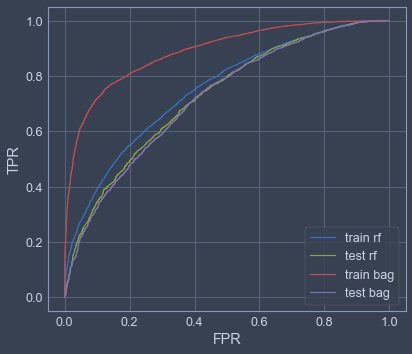

In [215]:
y_pred_test_rf = clf_rf.predict_proba(X_test)[:, 1]
y_pred_train_rf = clf_rf.predict_proba(X_train)[:, 1]


print('Train RF:')
show_auc(y_train, y_pred_train_rf, 'train rf')
print('Test RF:')
show_auc(y_test, y_pred_test_rf, 'test rf')
print('Train:')
show_auc(y_train, y_pred_train, 'train bag')
print('Test:')
show_auc(y_test, y_pred_test, 'test bag')
plt.legend();

plt.legend();

## Решение конец

#### Важность признаков
В sklearn - усредненное по всем деревьям в ансамбле кол-во сплитов по признаку, взвешенное на прирост информации (Information gain) и долю объектов в вершине, в которой производится этот сплит

Это не единственный вариант, см здесь:

https://medium.com/@ceshine/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3

Важности признаков случайного леса лежат в артибуте **feature\_importances\_**

In [245]:
imp = pd.Series(clf_rf.feature_importances_)
imp.sort_values(ascending=False)

43     0.506056
159    0.090784
143    0.055437
180    0.044626
176    0.042614
115    0.034666
126    0.022931
10     0.020559
109    0.014370
34     0.013116
8      0.011843
12     0.011379
175    0.011049
95     0.008645
28     0.008182
19     0.006841
138    0.006522
214    0.004978
85     0.004039
83     0.003276
190    0.003132
91     0.003007
80     0.002950
96     0.002787
70     0.002670
63     0.002591
47     0.002370
99     0.002300
50     0.002140
30     0.002017
         ...   
98     0.000000
189    0.000000
92     0.000000
192    0.000000
90     0.000000
178    0.000000
193    0.000000
84     0.000000
194    0.000000
82     0.000000
110    0.000000
113    0.000000
134    0.000000
114    0.000000
133    0.000000
130    0.000000
128    0.000000
127    0.000000
186    0.000000
125    0.000000
124    0.000000
122    0.000000
121    0.000000
120    0.000000
119    0.000000
118    0.000000
117    0.000000
116    0.000000
187    0.000000
218    0.000000
Length: 219, dtype: floa

Плюсы random_forest:
- устойчив к переобучению
- устойчивость к выбросам
- дает хорошее качество “из коробки”
- встроенная оценка важности признаков
- быстрая реализация

Минусы:
- сложность интерпретации по сравнению с одним деревом
- плохо справляется с очень большим числом признаков
- работает дольше линейных моделей

# Часть 4. Композиции моделей разных типов

Главная идея - почему ансамблирование моделей делается таким простым способом, как усреднение? Что если доверить это делому другому алгоритму машинного обучения?

## Блендинг
<img src="img/stacking.png" style="max-width: 680px; display: inline" />

Основной недостаток - деление обучающей выборки. Никакой из алгоритмов не использует всех данных для обучения.

## Стекинг

Используем идею K-Fold проверки. Выборку разбиваем на фолды, затем последовательно перебираем фолды и обучаем базовые алгоритмы на всех фолдах, кроме одного, а на оставшемся получаем ответы базовых алгоритмов и трактуем их как значения соответствующих признаков на этом фолде. Для получения метапризнаков объектов тестовой выборки базовые алгоритмы обучают на всей обучающей выборке и берут их ответы на тестовой.

<img src="img/stacking-2b.png" style="max-width: 680px; display: inline" />

### Практика

Смешаем дерево и логистическую регрессию

**Создаем признакии**

1. Заменяем пропуски на медианы
2. Создаем индикаторы пропущенных значений
3. Создаем дамми-переменные для категорий
4. Нормируем признаки

### Обучим логистическую регрессию

In [222]:
from sklearn.preprocessing import StandardScaler

train_median = d_train[num_feat].median()

X_train_lin = pd.concat([d_train[num_feat].fillna(train_median),
                     d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

X_test_lin = pd.concat([d_test[num_feat].fillna(train_median),
                     d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train_lin[num_feat])

X_train_lin[num_feat] = scaler.transform(X_train_lin[num_feat])
X_test_lin[num_feat] = scaler.transform(X_test_lin[num_feat])

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [224]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(penalty='l1', C=0.1)

clf_lr.fit(X_train_lin, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Train:
ROC AUC: 0.7324
Test:
ROC AUC: 0.7240


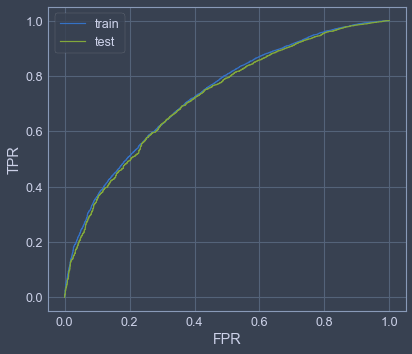

In [226]:
y_pred_lin_test = clf_lr.predict_proba(X_test_lin)[:, 1]
y_pred_lin_train = clf_lr.predict_proba(X_train_lin)[:, 1]

print('Train:')
show_auc(y_train, y_pred_lin_train, 'train')
print('Test:')
show_auc(y_test, y_pred_lin_test, 'test')
plt.legend();

Будем строить линейную комбинацию логистической регрессии и случайного леса вида 

$y = \alpha y_1 + (1 - \alpha) y_2$

Параметр $\alpha$ переберем по сетке от 0 до 1, оценивая качество на тестовой выборке

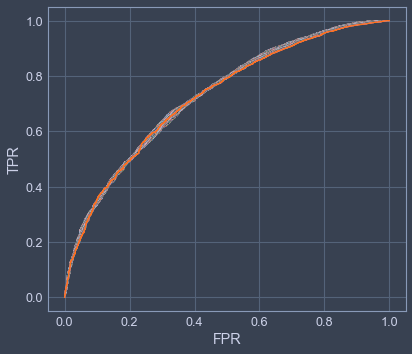

In [231]:
aucs = []
alpha_space = np.linspace(0, 1, 100)
for alpha in alpha_space:
    y_pred_weight = alpha * y_pred_lin_test + (1 - alpha) * y_pred_test_rf
    aucs.append(show_auc(y_test, y_pred_weight, prin=False, plot_label=str(alpha)))
aucs = np.array(aucs)    

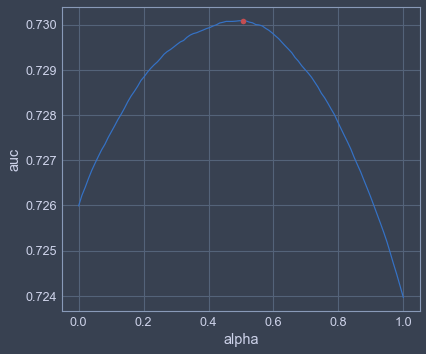

In [232]:
max_ind = np.where(aucs == aucs.max())[0]
alpha = alpha_space[max_ind]

plt.plot(alpha_space, aucs)
plt.plot(alpha_space[max_ind], aucs[max_ind], 'o', c='r')
plt.xlabel('alpha')
plt.ylabel('auc')

#итоговое взвешенное предсказание
y_pred_weight = alpha * y_pred_lin_test + (1 - alpha) * y_pred_test_rf

Сравним 3 метода (приблизим график ROC кривой, чтобы увидеть разницу)

Weighted:
ROC AUC: 0.7301
Log regression:
ROC AUC: 0.7240
Random forest:
ROC AUC: 0.7260


(0.5, 0.8)

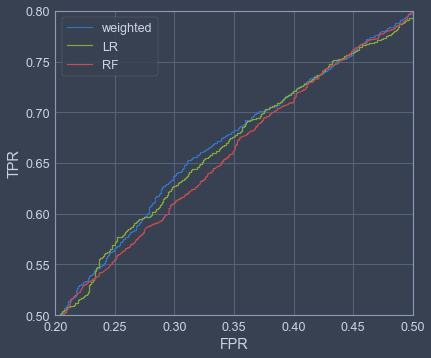

In [234]:
print('Weighted:')
show_auc(y_test, y_pred_weight, 'weighted')
print('Log regression:')
show_auc(y_test, y_pred_lin_test, 'LR')
print('Random forest:')
show_auc(y_test, y_pred_test_rf, 'RF')
plt.legend();
plt.xlim(0.2, 0.5)
plt.ylim(0.5, 0.8)

### Попробуем стекинг

In [238]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict_proba(X_train.iloc[test_ind])[:, 1]
        meta_test += clf.predict_proba(X_test)[:, 1]
    
    return meta_train, meta_test / stack_cv.n_splits

In [239]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=555)

meta_train = []
meta_test = []
col_names = []

print('LR features...')
meta_tr, meta_te = get_meta_features(clf_lr, X_train_lin, y_train, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(clf_rf, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

LR features...


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

RF features...


In [240]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

#### Стэкинг мета-признаков с помощью LR
Используем регуляризованную лог регрессию в качестве алгоритма второго уровня

In [241]:
clf_lr_meta = LogisticRegression(penalty='l2', C=1)
clf_lr_meta.fit(X_meta_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

ROC AUC: 0.7318


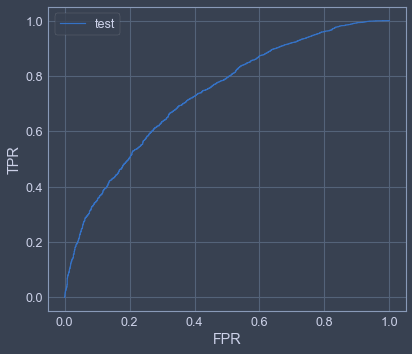

In [243]:
y_pred_meta_test = clf_lr_meta.predict_proba(X_meta_test)[:, 1]

show_auc(y_test, y_pred_meta_test, 'test')
plt.legend();

#### Посмотрим на коэффициенты объединяющей линейной модели

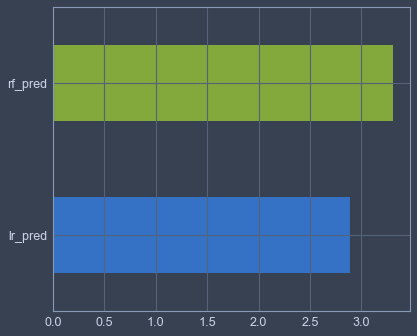

In [244]:
pd.Series(clf_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh')

# Домашняя работа

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками